## *Part 1*

## Building a Face-Tracking Model from scratch  

This project will deploy a custom Face-Tracking Model in Real-Time using:
- Augumentation of images for variations using [Albumentations](https://albumentations.ai/)
- Modified CNN classification layer for implementing a bounding-box layer using [VGG16](https://keras.io/api/applications/vgg/) 
- Image annotation using [Labelme](https://github.com/wkentaro/labelme), This project will explore a Bounding-box style annotation 
- Track, Capture and plot coordinates using [OpenCV](https://opencv.org/)

### Imports and Create folders for Images and labels

In [3]:
import tensorflow as tf
import json
import keras 
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from keras.applications import VGG16
from keras.models import load_model

from matplotlib import pyplot as plt
import albumentations as alb
from albumentations import (Compose, RandomBrightnessContrast, ImageCompression, 
HueSaturationValue, RandomContrast, HorizontalFlip, Rotate, RandomCrop, VerticalFlip, RGBShift,
RandomGamma)

import matplotlib
import cv2
import uuid
import os
import time
import numpy as np


matplotlib.use('TkAgg')
%matplotlib inline

IMAGES_PATH = os.path.join('data', 'images')
number_of_imgs = 90

if not os.path.exists(IMAGES_PATH):
    os.makedirs(IMAGES_PATH)

### Capture 90 Images using OpenCV (Modifiable)

In [4]:
cap = cv2.VideoCapture(0)   

for imgnum in range(number_of_imgs):

    if len(os.listdir(IMAGES_PATH)) == number_of_imgs:
        print('Max numebr of images reached - Please remove before collecting')
        break 

    else:

        if imgnum == 0:
            print('Image cap not reached - Proceed to collect')

        print('Collecting image {}'.format(imgnum))
        ret, frame = cap.read()
        imgname = os.path.join(IMAGES_PATH,f'{(str(uuid.uuid1()))}.jpg')
        cv2.imwrite(imgname, frame)
        cv2.imshow('frame', frame)
        time.sleep(0.25)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

Max numebr of images reached - Please remove before collecting


### Launch labelme and draw bounding box around the faces

In [28]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\danie\.labelmerc


### Example

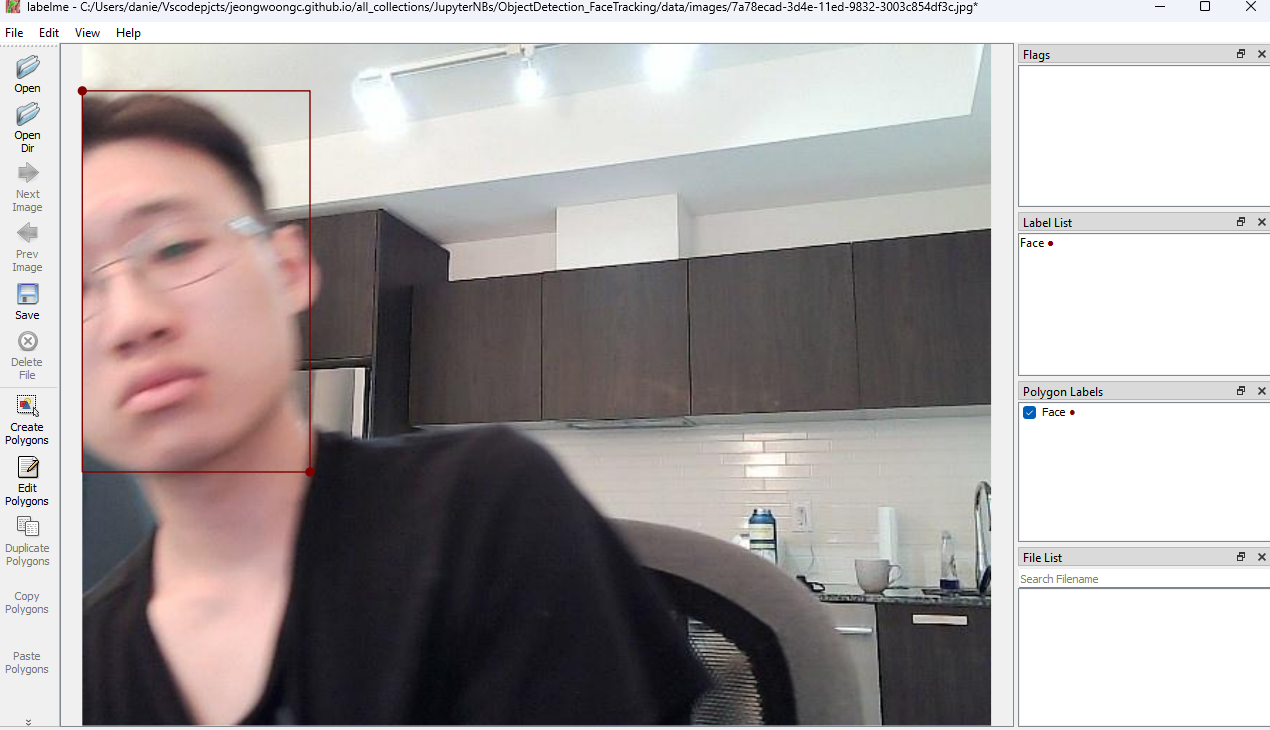

Prevent GPU memory growth with `tf.config.experimental.set_memory_growth`.
- This is neccessary since we dont want over allocate our GPU memory for our model

Then, we need to store our images as a list of numbers based on the bytes which can be decoded with the use of `tf.io.decode_jpeg`. This will let us extract coordinates of each image. (The images are of the same size)

In [5]:
# limit GPU memory growth to avoid OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU)')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# load image into TF dataset file 
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=False)

def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

images = images.map(load_image)
images.as_numpy_iterator().next()

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [241, 255, 255],
        [241, 255, 255],
        [241, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [241, 255, 255],
        [241, 255, 255],
        [241, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [241, 255, 255],
        [241, 255, 255],
        [241, 255, 255]],

       ...,

       [[122, 127, 120],
        [122, 127, 120],
        [121, 126, 119],
        ...,
        [ 83,  85,  84],
        [ 86,  88,  87],
        [ 89,  91,  90]],

       [[116, 119, 110],
        [116, 119, 110],
        [116, 119, 110],
        ...,
        [ 84,  86,  85],
        [ 87,  87,  87],
        [ 91,  91,  91]],

       [[114, 115, 107],
        [114, 115, 107],
        [115, 116, 108],
        ...,
        [ 83,  85,  84],
        [ 88,  88,  88],
        [ 91,  91,  91]]

In [6]:
image_generator = images.batch(4).as_numpy_iterator()

We can try plotting the stored images using numpy since we can now access them through our tensorflow dataset. The below example uses a batch size of 4.

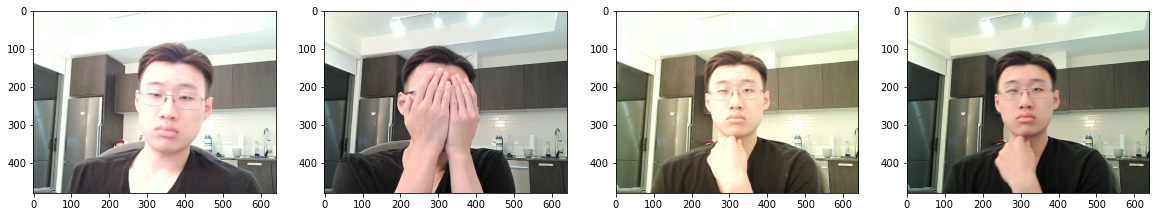

In [7]:
plot_images = image_generator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,5))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

### Create destination folders for augumentation images 

In [29]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

### Apply augumentation on a test image 

Here, we can add different augumentation techniques as we like. 

This determines how it will distort the images 

In [30]:
transforms = Compose([
            Rotate(limit=40),
            RandomBrightnessContrast(p=0.2),
            RandomCrop(width=450, height=450),
            ImageCompression(quality_lower=85, quality_upper=100, p=0.5),
            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            RGBShift(p=0.2),
            RandomGamma(p=0.2)], 
            bbox_params=alb.BboxParams(format='albumentations',
                                        label_fields=['class_labels']))
                                        


This function actually applies the Transformations by casting and resizing as a tensorflow dataset entity

In [31]:

def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img


This function groups the image with its label

In [33]:

def process_data(image, label, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label

We can load test img and annotation by passing in the destination of our images/labels. Note that the label is a `json` file.

In [ ]:
check_img = cv2.imread(os.path.join('data','train','images','b8cae046-3fa7-11ed-947a-3003c854df3c.jpg'))
with open(os.path.join('data', 'train', 'labels', 'b8cae046-3fa7-11ed-947a-3003c854df3c.json'), 'r') as f:
    label = json.load(f)


We can extract 4 corner coordinates using and rescale by dividing by the set resolution (640x480)

In [37]:

print(label['shapes'][0]['points'])

coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

print(coords)
coords = list(np.divide(coords,[640,480,640,480]))
print(coords)


[[232.1830985915493, 93.66197183098592], [431.47887323943667, 321.1267605633803]]


Apply augumentations and view result

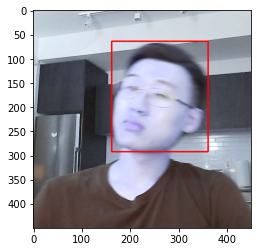

In [42]:
augmented = transforms(image=check_img, bboxes=[coords], class_labels=['face'])
augmented['bboxes'][0][2:]
augmented['bboxes']

cv2.rectangle(augmented['image'],
                tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
                tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
                    (255,0,0),2)

plt.imshow(augmented['image'])
plt.show()

### Complete augumentation function for all images instead of 1 sample 

In [10]:
for partition in ['train','test','val']:

    if len(os.listdir(os.path.join('aug_data',partition,'images'))) > 0:
        print('Augmentation already exists')

        break
    
    for img in os.listdir(os.path.join('data',partition,'images')):
        
        if os.path.exists(img):
            raise Exception 

        img_cv = cv2.imread(os.path.join('data', partition, 'images',img))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels',f'{img.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords,[640,480,640,480]))

        # note that we are creating 100 variations for each transformation techniques 
        try:
            for x in range(100):
                augmented = transforms(image=img_cv, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{img.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = img

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bboxes'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bboxes'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bboxes'] = [0,0,0,0]
                    annotation['class'] = 0

                with open(os.path.join('aug_data',partition, 'labels', f'{img.split(".")[0]}.{x}.json'),'w') as f:
                    json.dump(annotation, f)
        
        except Exception as e:
            print(e)

Augmentation already exists


We now load/convert in our augumented images as well using the `load_image` function from earlier

In [11]:
for augfold in ['train', 'val', 'test']:
    dsimages = tf.data.Dataset.list_files('aug_data\\{}\\images\\*.jpg'.format(augfold), shuffle=False)
    if augfold == 'train':
        train_images = dsimages.map(load_image)
        train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
        train_images = train_images.map(lambda x: x/255)
    elif augfold == 'test':
        test_images = dsimages.map(load_image)
        test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
        test_images = test_images.map(lambda x: x/255)
    else:
        val_images = dsimages.map(load_image)
        val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
        val_images = val_images.map(lambda x: x/255)

Also the same with our labels that match our images. Note that we seperate our images/labels into 3 partitions of train, test and evaluate folders.

In [12]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    
    return [label['class']], label['bboxes']

for laugfold in ['train', 'val', 'test']:
    dsimages_l = tf.data.Dataset.list_files('aug_data\\{}\\labels\\*.json'.format(laugfold), shuffle=False)
    if laugfold == 'train':
        train_labels = dsimages_l.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
    elif laugfold == 'test':
        test_labels = dsimages_l.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
    else:
        val_labels = dsimages_l.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

This function will check if both our images and labels have the same amount of contents. If the Exception is raised the contents are mismatched. Note that every image **must** have its corresponding label to be used within the model.

In [13]:
count_dict = {}
for e in [len(train_images),len(train_labels),len(test_images),len(test_labels),len(val_images),len(val_labels)]:
    if e == len(train_images):
            count_dict['train'] = e
    elif (e == len(test_images) and e == len(val_images)):
        count_dict['test'] = e
        count_dict['val'] = e
    elif e == len(test_images):
        count_dict['test'] = e
    elif e == len(val_images):
        count_dict['val'] = e 
    else:
        raise Exception

Zip label and images together to pair up the numpy arrays. This will create the final dataset used to train the model. We use a batch size of 8 since that is enough. 

In [14]:
data_batch = 8
data_prefetch = 4

train = tf.data.Dataset.zip((train_images,train_labels))
train = train.shuffle(count_dict['train'])
train = train.batch(data_batch)
train = train.prefetch(data_prefetch)

test = tf.data.Dataset.zip((test_images,test_labels))
test = test.shuffle(count_dict['test'])
test = test.batch(data_batch)
test = test.prefetch(data_prefetch)

val = tf.data.Dataset.zip((val_images,val_labels))
val = val.shuffle(count_dict['test'])
val = val.batch(data_batch)
val = val.prefetch(data_prefetch)

We can also loop through the combined label and image and plot to view.  Reference 0 for image and 1 for label since they are in a nested list format.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


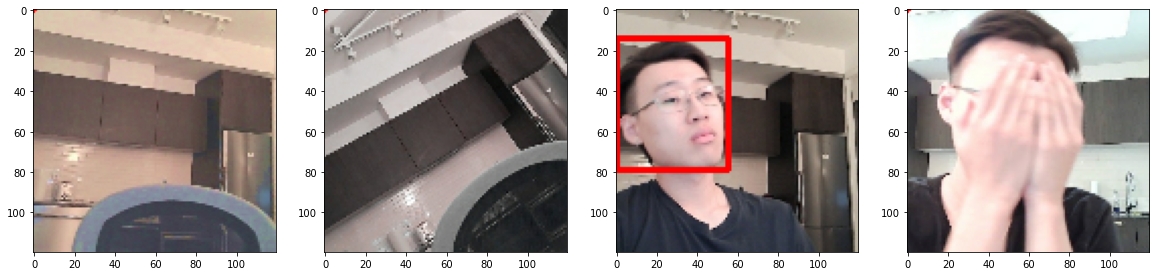

In [15]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                    (255,0,0),2)

    ax[idx].imshow(sample_image)

### Build deep learning layers 

Reference from SSD neural networks we can use a `VGG16` CNN library from Keras

In [16]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    # include_top=False is for removing vgg16 pre-made classification and softmax layer since we want our own
    vgg = VGG16(include_top=False)(input_layer)
    
    # Classification Model 
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Regression model 
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [17]:
# verify model
facetracker = build_model()
X, y = train.as_numpy_iterator().next()
X.shape

(8, 120, 120, 3)

We use `GlobalMaxPooling2D` layer before the dense layer to reduce dimensionality of the feature maps.

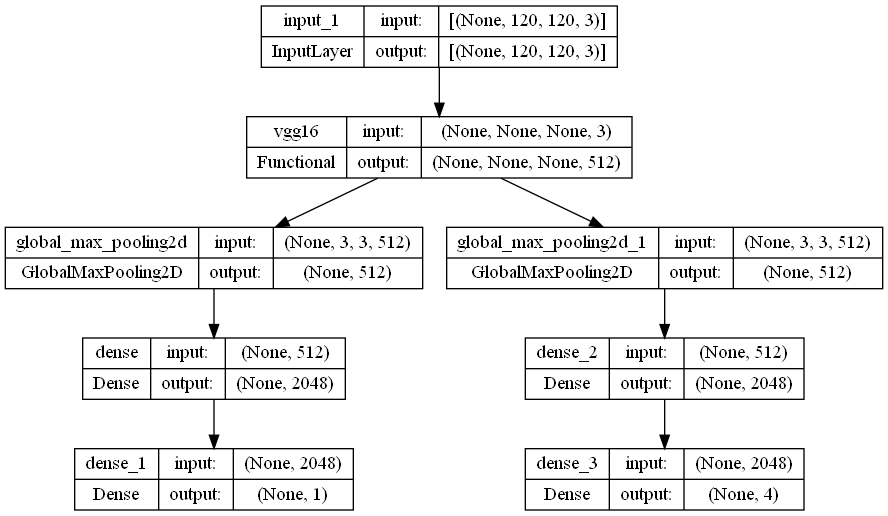

In [46]:
tf.keras.utils.plot_model(facetracker, show_shapes=True)


### Train the model

In [18]:
classes, coords = facetracker.predict(X)
classes, coords

1/1 [==============================] - 8s 8s/step


(array([[0.3667562 ],
        [0.40642202],
        [0.36330926],
        [0.3907553 ],
        [0.4725758 ],
        [0.42605066],
        [0.46184438],
        [0.47173664]], dtype=float32),
 array([[0.72152835, 0.4361935 , 0.5726446 , 0.5188907 ],
        [0.74950135, 0.33891973, 0.5283973 , 0.39032257],
        [0.7074752 , 0.43658277, 0.60891443, 0.4859862 ],
        [0.738741  , 0.45397037, 0.6482869 , 0.5476132 ],
        [0.6316802 , 0.3859447 , 0.7158362 , 0.5574167 ],
        [0.6927638 , 0.4225423 , 0.6032667 , 0.43580058],
        [0.6462465 , 0.45261604, 0.5381893 , 0.5538471 ],
        [0.62831646, 0.45933098, 0.5674415 , 0.53617483]], dtype=float32))

We now require a way to determine our loss metrics. 

We can utilize the loss function used in YOLO (You Only Look Once)

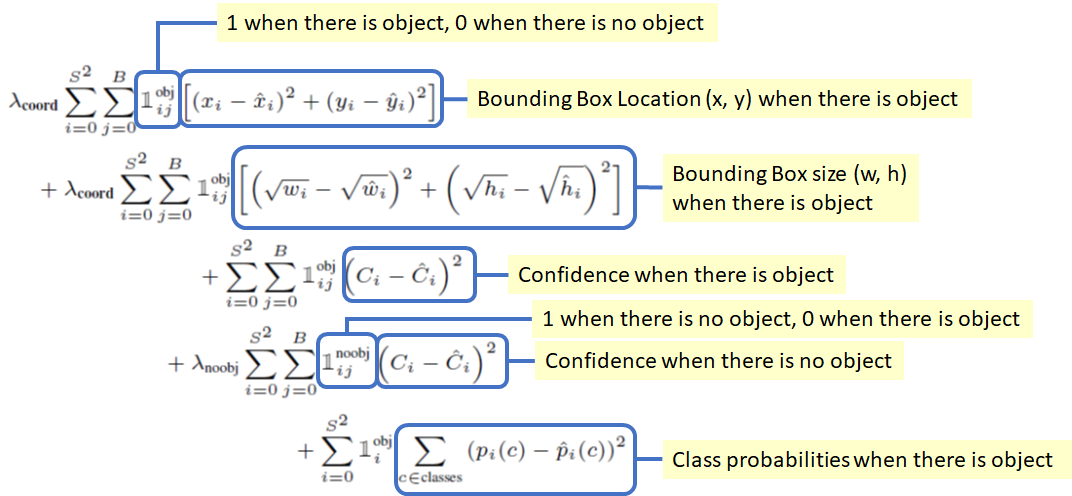

We can turn this into our function:

In [19]:
batches_per_epoch = len(train)
lr_decay = (1./0.75-1)/batches_per_epoch
opt = tf.keras.optimizers.Adam(learning_rate=0.000095, decay=lr_decay)

def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2]-yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    return delta_coord + delta_size



We also require a classification function. 

We can simply use binary cross entropy for classification. Since this fits our required criteria for 

increaseing/decreasing our probabilities based on the binary outcomes of our possible coordiates.

In [47]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [20]:
classloss(y[0], classes).numpy()
regressloss(y[1], coords).numpy()

### Build customized face tracking model

In [21]:

class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

model = FaceTracker(facetracker)
model.compile(opt, classloss, regressloss)

### Train the custom model

We can use Tensorboard for easy access of our training data.

In [22]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])
hist.history

Epoch 1/10
638/638 [==============================] - 64s 79ms/step - total_loss: 0.5381 - class_loss: 0.1511 - regress_loss: 0.4625 - val_total_loss: 2.6054 - val_class_loss: 2.1610 - val_regress_loss: 1.5249
Epoch 2/10
638/638 [==============================] - 49s 67ms/step - total_loss: 0.1208 - class_loss: 0.0307 - regress_loss: 0.1055 - val_total_loss: 2.0111 - val_class_loss: 2.1698 - val_regress_loss: 0.9261
Epoch 3/10
638/638 [==============================] - 49s 67ms/step - total_loss: 0.1085 - class_loss: 0.0283 - regress_loss: 0.0944 - val_total_loss: 0.0167 - val_class_loss: 5.4241e-06 - val_regress_loss: 0.0167
Epoch 4/10
638/638 [==============================] - 49s 67ms/step - total_loss: 0.0707 - class_loss: 0.0193 - regress_loss: 0.0611 - val_total_loss: 0.0241 - val_class_loss: 1.1503e-04 - val_regress_loss: 0.0240
Epoch 5/10
638/638 [==============================] - 49s 67ms/step - total_loss: 0.0561 - class_loss: 0.0159 - regress_loss: 0.0482 - val_total_loss: 7

{'total_loss': [0.02812330052256584,
  0.010272982530295849,
  0.0066523621790111065,
  0.006745568010956049,
  0.004426869563758373,
  0.0025302995927631855,
  0.0006373955402523279,
  0.010389878414571285,
  0.0007188209565356374,
  0.0035121403634548187],
 'class_loss': [0.008207278326153755,
  8.370525029022247e-05,
  0.00042771489825099707,
  5.4632087994832546e-05,
  0.002907882910221815,
  1.13248984234815e-06,
  3.7508518289541826e-05,
  0.007061131298542023,
  7.927517799544148e-06,
  2.980232594040899e-08],
 'regress_loss': [0.02401966042816639,
  0.010231129825115204,
  0.006438504904508591,
  0.00671825185418129,
  0.0029729283414781094,
  0.0025297333486378193,
  0.0006186412647366524,
  0.006859312765300274,
  0.000714857189450413,
  0.003512125462293625],
 'val_total_loss': [2.6053528785705566,
  2.0110630989074707,
  0.01669805869460106,
  0.0240936242043972,
  7.5894341468811035,
  1.653040885925293,
  3.109067916870117,
  3.3681297302246094,
  2.904801368713379,
  1.0

### Training results

The result is satisfactory even though there are inaccuracies between the validation loss/actual loss. This could have been due to our dataset since the model only had 90 images to work with which was split into 3 paritions. 

To tune this model:
- We can increase the amount of images in all partitions
- Increase batch sizes
- Modify augumentation data
- Set dropout rate for overfitting

Overall, this model will work

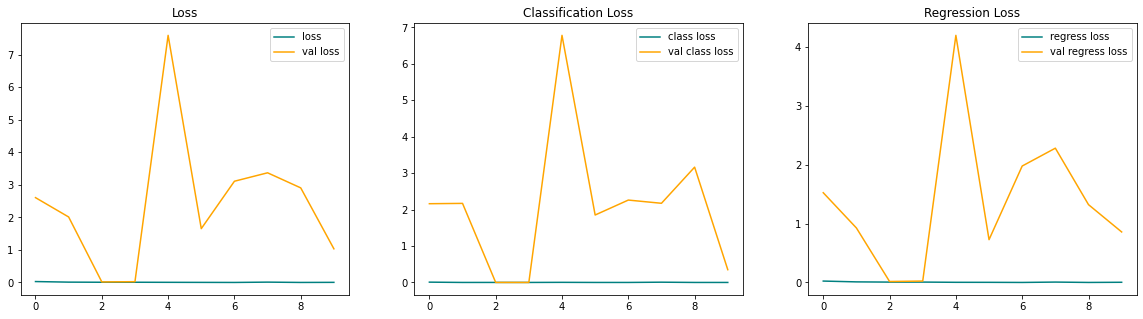

In [23]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()
test_data = test.as_numpy_iterator()

We can test our model on a few random images in the test samples.

According to the results seen, the model does perform quite well

1/1 [==============================] - 0s 32ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


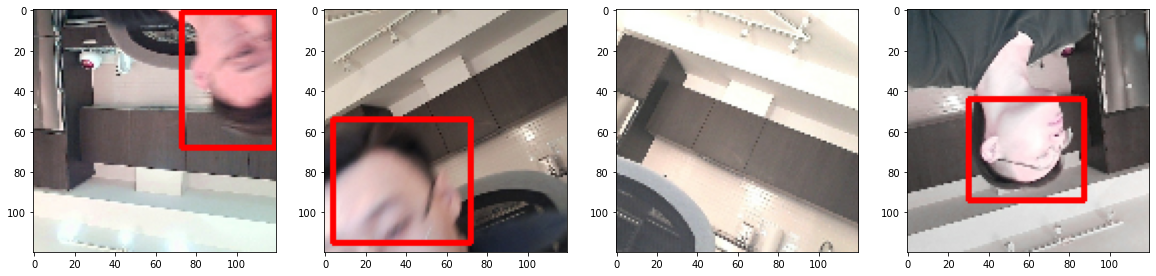

In [24]:
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                        tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                        tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                                (255,0,0),2)

    ax[idx].imshow(sample_image)

### Save the model for future use

In [25]:
facetracker.save('facetracker.h5')
facetracker = load_model('facetracker.h5')

### Real-Time Detection

This works by utilizing `OpenCV` to plot the top left corner and bottom right corner of the bounding-box every time our classifier exceeds the threshhold percentage of 0.5 according to the position of our face inside the designated resolution. This means that the predicions are made constantly. 

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

Here, we can see that the model will stop plotting the bounding-box when we cover our face with a hand. 

The hand will bring down the probability of our plotting which was mentioned above.

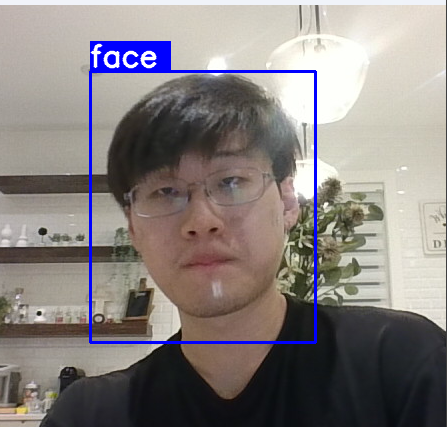

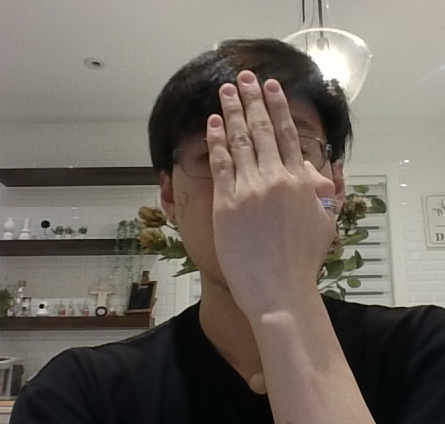

--- 

## *Part 2*

## Arduino Communication for servo control

We can now load our trained custom model and use python `serial` library to translate our predicted positional data to Y & X axis servo motors.

In [ ]:
import cv2
import math
import numpy as np
import serial
import time 
import tensorflow as tf
from keras.models import load_model

### Load our model

In [ ]:
facetracker = load_model('facetracker.h5')

We can connect our arduino serial and use `coord_send` function to send our X & Y coordinates.

The function sends the predicted center in the form of `string` `bytes` 

In [ ]:
arduino = serial.Serial(port='COM5', baudrate=9600)
time.sleep(3)

def coord_send(center):

    string_centerX = str(center[0])
    string_centerY = str(center[1])

    arduino.write(chr(88).encode('utf-8'))
    arduino.write(bytes(string_centerX,'utf-8'))
    arduino.write(chr(89).encode('utf-8'))
    arduino.write(bytes(string_centerY,'utf-8'))

    return 

This part is a slightly modified real-time detection code from part 1 to send coordinate data to the arduino as predictions happen real-time.

**Current functional build is a platform that can track the face with a phone
acting as the camera. This will be updated further since this is only version 1 of the camera control.**

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (0,255,0), 2)
        
        # Configure center dot
        start_dot = np.multiply(sample_coords[:2], [450,450]).astype(int)
        end_dot = np.multiply(sample_coords[2:], [450,450]).astype(int)

        center_factor = np.divide(end_dot-start_dot, [2,2]).astype(int)
        center_coord = np.add(center_factor, start_dot).astype(int)

        cv2.circle(frame, center_coord, 5, (255, 0, 255), cv2.FILLED) 

        # Send coordinate to arduino
        coord_send(center_coord)

        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [100,0])), 
                            (0,255,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'Daniel', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv2.LINE_AA)    
    
    cv2.imshow('FaceTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()